In [1]:
from copy import deepcopy

import dynamic_properties as dynprop
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from data_utils import get_gfp_peaks
from eeg_recording import SingleSubjectRecording
from IPython.display import display
from scipy.spatial.distance import cosine

plt.style.use("papers")
plt.rcParams.update(
    {
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
    }
)
pw.overwrite_axisgrid()

<Figure size 72x72 with 0 Axes>

In [2]:
def get_random_gaussian_data(
    n_channels, length, sampling_rate, avg_reference=True, seed=None
):
    """
    Get Gaussian data of length with n_channels. Data are sampled from multivariate
    normal distribution with random mean in N(0, 1) and random covariance computed as
    cov = A dot A' with A random matrix with elements from N(0, 1).
    """
    np.random.seed(seed)
    random_cov = np.random.normal(0.0, 1.0, size=(n_channels, n_channels))
    data = pd.DataFrame(
        np.random.multivariate_normal(
            # mean=np.random.normal(0.0, 1.0, size=n_channels),
            mean=[0.0] * n_channels,
            cov=np.dot(random_cov, random_cov.transpose()),
            size=(int(length * sampling_rate)),
        ),
        columns=[f"chan {i}" for i in range(n_channels)],
        index=np.arange(0, length, 1 / sampling_rate),
    )
    if avg_reference:
        data = data.subtract(data.mean(axis=1), axis=0)

    return data

def cosine_dist_w_perm_test(x, y, n_perm=20000):
    data = cosine(x, y)
    perms_dist = []
    for j in range(n_perm):
        perm = np.random.permutation(x)
        perms_dist.append(cosine(perm, y))
    p_val = 1. - (np.sum(data > perms_dist) / float(n_perm))
    return data, p_val


def cosine_dist_w_mc_test(x, y, trans_mat, n_perm=1000, burn_in=100):
    data = cosine(x, y)
    perms_dist = []
    n_states = len(np.unique(x))
    for j in range(n_perm):
        ts = [np.random.choice(n_states)]
        for t in range(x.shape[0] + burn_in - 1):
            ts.append(np.random.choice(np.arange(n_states), p=trans_mat[ts[-1], :]))
        ts = np.array(ts)[burn_in:]
        assert len(ts) == len(y)
        perms_dist.append(cosine(ts, y))
    p_val = 1. - (np.sum(data > perms_dist) / float(n_perm))
    return data, p_val

In [3]:
SAMPLING_RATE = 250.0  # Hz
LENGTH = 10.0  # seconds
N_CHANNELS = 3
N_STATES = 2
USE_GFP = True
ENVELOPE = False

data = get_random_gaussian_data(N_CHANNELS, LENGTH, SAMPLING_RATE, seed=43)
info = mne.create_info(
    ch_names=list(data.columns), ch_types=["eeg"] * N_CHANNELS, sfreq=SAMPLING_RATE
)
mne_data = mne.io.RawArray(data.values.T, info)
if USE_GFP:
    peaks, _ = get_gfp_peaks(data.values.T)
    data["GFP"] = "--"
    data.iloc[peaks, -1] = "GFP peak"

if ENVELOPE:
    data_copy = deepcopy(mne_data)
    mne_data = data_copy.apply_hilbert(envelope=True)
    env_peaks, _ = get_gfp_peaks(data_copy.get_data())
    data["envelope GFP"] = "--"
    data.iloc[env_peaks, -1] = "envelope GFP peak"


recording = SingleSubjectRecording(subject_id="IID", data=mne_data)

reference = xr.open_dataarray("dummy_reference.nc")

Creating RawArray with float64 data, n_channels=3, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.


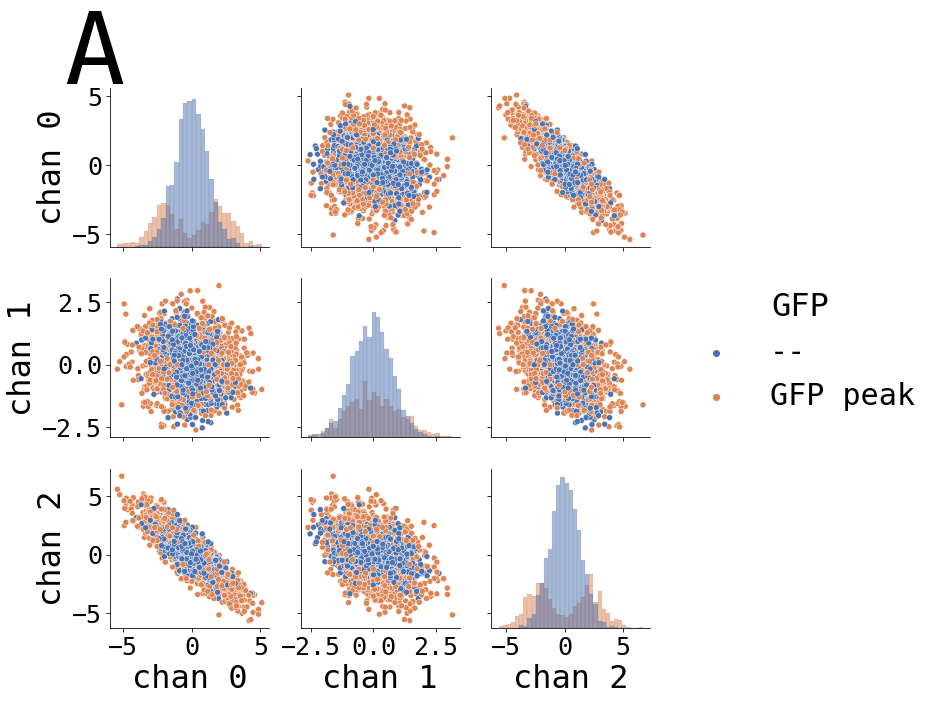

In [4]:
plot_vars = [f"chan {i}" for i in range(N_CHANNELS)]
g = sns.pairplot(
    data=data,
    vars=plot_vars,
    hue="GFP" if USE_GFP else None,
    palette="deep",
    diag_kind="hist",
)
g.axes[0, 0].text(
    -0.1,
    1.2,
    "A",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g0 = pw.load_seaborngrid(g)
g0.savefig(quick=True)

In [5]:
all_stats = pd.DataFrame()
dyn_stats = pd.DataFrame()
maps = []


def save_suff(recording, algo, gfp):
    global maps
    global all_stats
    global dyn_stats
    global data

    gfp = "GFP peaks" if gfp else "no GFP peaks"

    data[f"{algo}: {gfp}"] = recording.latent_segmentation
    maps.append(
        xr.DataArray(
            recording.latent_maps,
            dims=["latent map", "channels"],
            coords={
                "latent map": ["A", "B"],
                "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
            },
        )
        .assign_coords({"algorithm": algo, "GFP": gfp})
        .expand_dims(["algorithm", "GFP"])
    )
    recording.compute_segmentation_stats()
    df = recording.get_stats_pandas().copy()
    df["algorithm"] = algo
    df["GFP"] = gfp
    all_stats = pd.concat([all_stats, df], axis=0)

    aif1 = dynprop.lagged_mutual_information(
        recording.latent_segmentation, 2, max_lag=100, log2=True, pbar=False
    )

    dy_st = {
        "mixing time": dynprop.mixing_time(
            dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
        ),
        "entropy": dynprop.H_1(recording.latent_segmentation, 2, log2=True),
        "max entropy": dynprop.max_entropy(2, log2=True),
        "entropy rate": dynprop.excess_entropy_rate(
            recording.latent_segmentation, 2, kmax=6, log2=True
        )[0],
        "MC entropy rate": dynprop.markov_chain_entropy_rate(
            dynprop.empirical_distribution(recording.latent_segmentation, 2),
            dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
            log2=True,
        ),
        "AIF 1st peak": dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1],
        "algorithm": algo,
        "GFP": gfp,
    }
    dyn_stats = pd.concat([dyn_stats, pd.DataFrame(dy_st, index=[0])])

In [6]:
recording.run_latent_pca(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "PCA", True)

recording.run_latent_pca(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "PCA", False)


g = sns.pairplot(data=data, hue="PCA: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="PCA: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

display(pg.corr(data["PCA: GFP peaks"], data["PCA: no GFP peaks"], method="spearman"))
display(pg.chi2_independence(data, x="PCA: GFP peaks", y="PCA: no GFP peaks")[2])

n         r         CI95%  p-val  power
spearman  2500  0.986912  [0.99, 0.99]    0.0    1.0

test    lambda          chi2  dof  pval    cramer  power
0             pearson  1.000000   2430.020346  1.0   0.0  0.985905    1.0
1        cressie-read  0.666667   2391.445696  1.0   0.0  0.978048    1.0
2      log-likelihood  0.000000   2763.051017  1.0   0.0  1.051295    1.0
3       freeman-tukey -0.500000   3860.648391  1.0   0.0  1.242682    1.0
4  mod-log-likelihood -1.000000   7276.333663  1.0   0.0  1.706029    1.0
5              neyman -2.000000  78852.716304  1.0   0.0  5.616145    1.0

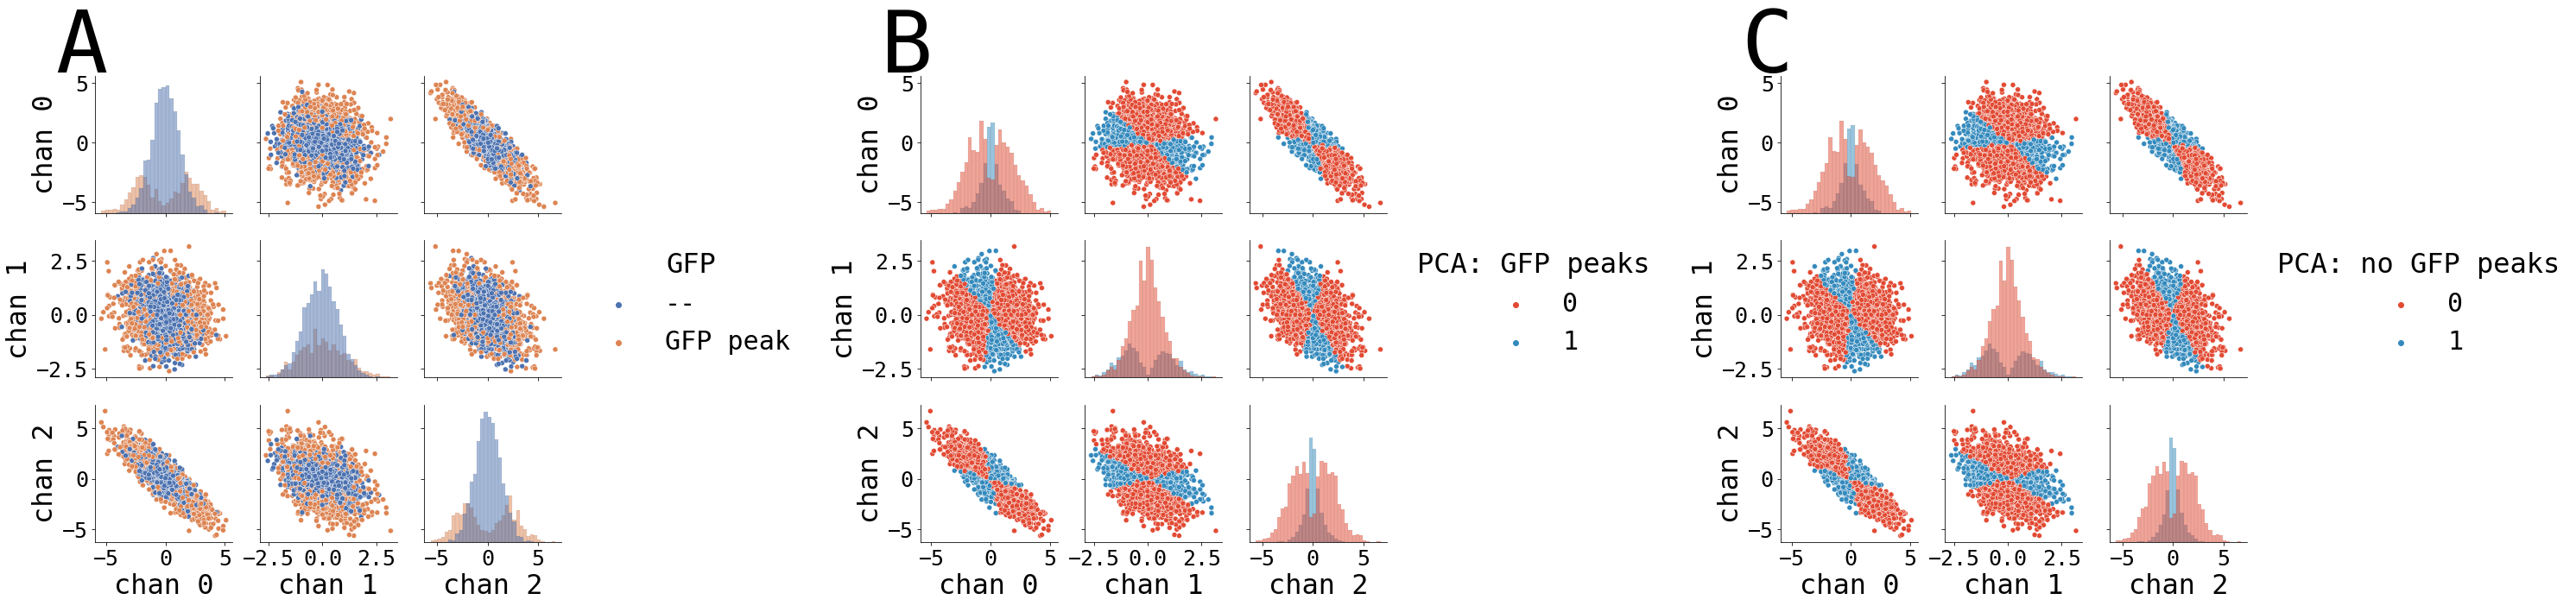

In [7]:
(g0 | g1 | g2).savefig(fname="PCA_algo.pdf", transparent=True)

In [8]:
recording.run_latent_ica(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "ICA", True)

recording.run_latent_ica(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "ICA", False)


g = sns.pairplot(data=data, hue="ICA: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="ICA: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["ICA: GFP peaks"], data["ICA: no GFP peaks"], method="spearman")
display(corr)
display(pg.chi2_independence(data, x="ICA: GFP peaks", y="ICA: no GFP peaks")[2])

n    r         CI95%  p-val  power
spearman  2500 -1.0  [-1.0, -1.0]    0.0      1

test    lambda          chi2  dof  pval     cramer  power
0             pearson  1.000000  2.495999e+03  1.0   0.0   0.999200    1.0
1        cressie-read  0.666667  2.638069e+03  1.0   0.0   1.027243    1.0
2      log-likelihood  0.000000  3.446551e+03  1.0   0.0   1.174147    1.0
3       freeman-tukey -0.500000  5.574675e+03  1.0   0.0   1.493275    1.0
4  mod-log-likelihood -1.000000  1.608412e+04  1.0   0.0   2.536464    1.0
5              neyman -2.000000  1.558705e+06  1.0   0.0  24.969621    1.0

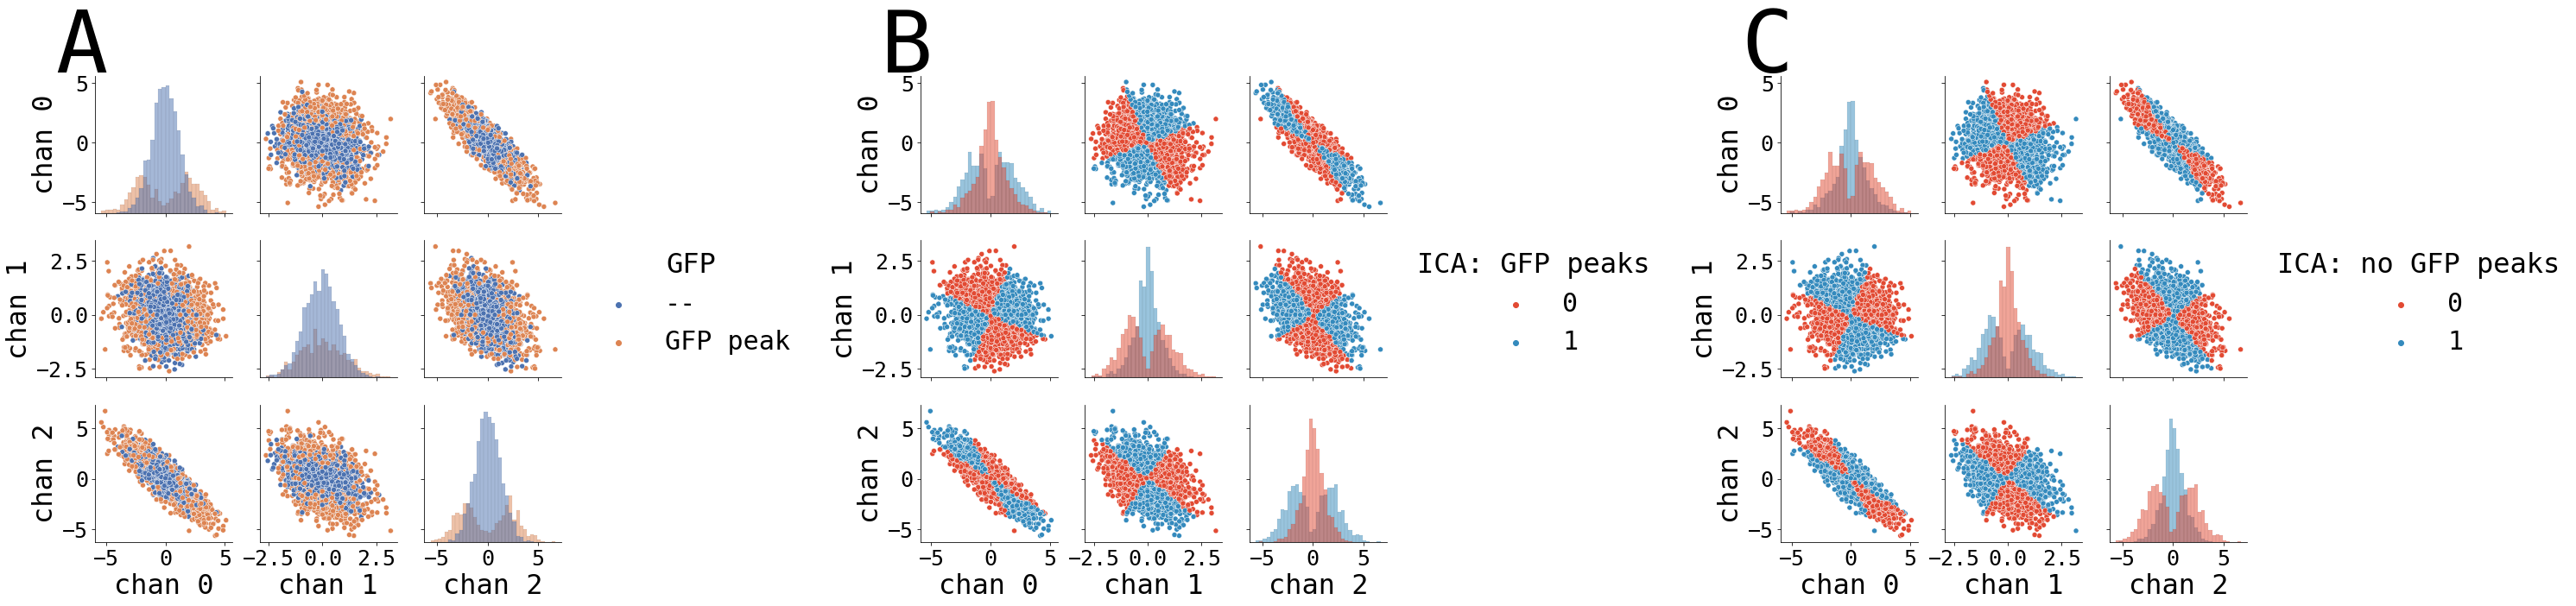

In [9]:
(g0 | g1 | g2).savefig(fname="ICA_algo.pdf", transparent=True)

In [10]:
recording.run_latent_kmeans(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "mod. K-Means", True)

recording.run_latent_kmeans(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "mod. K-Means", False)


g = sns.pairplot(
    data=data, hue="mod. K-Means: GFP peaks", vars=plot_vars, diag_kind="hist"
)
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(
    data=data, hue="mod. K-Means: no GFP peaks", vars=plot_vars, diag_kind="hist"
)
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

display(
    pg.corr(
        data["mod. K-Means: GFP peaks"],
        data["mod. K-Means: no GFP peaks"],
        method="spearman",
    )
)
display(pg.chi2_independence(data, x="mod. K-Means: GFP peaks", y="mod. K-Means: no GFP peaks")[2])

n         r           CI95%  p-val  power
spearman  2500 -0.944654  [-0.95, -0.94]    0.0    1.0

test    lambda          chi2  dof  pval    cramer  power
0             pearson  1.000000   2227.150049  1.0   0.0  0.943854    1.0
1        cressie-read  0.666667   2332.748057  1.0   0.0  0.965971    1.0
2      log-likelihood  0.000000   2850.522410  1.0   0.0  1.067806    1.0
3       freeman-tukey -0.500000   3810.214138  1.0   0.0  1.234539    1.0
4  mod-log-likelihood -1.000000   6123.370853  1.0   0.0  1.565039    1.0
5              neyman -2.000000  34332.483585  1.0   0.0  3.705805    1.0

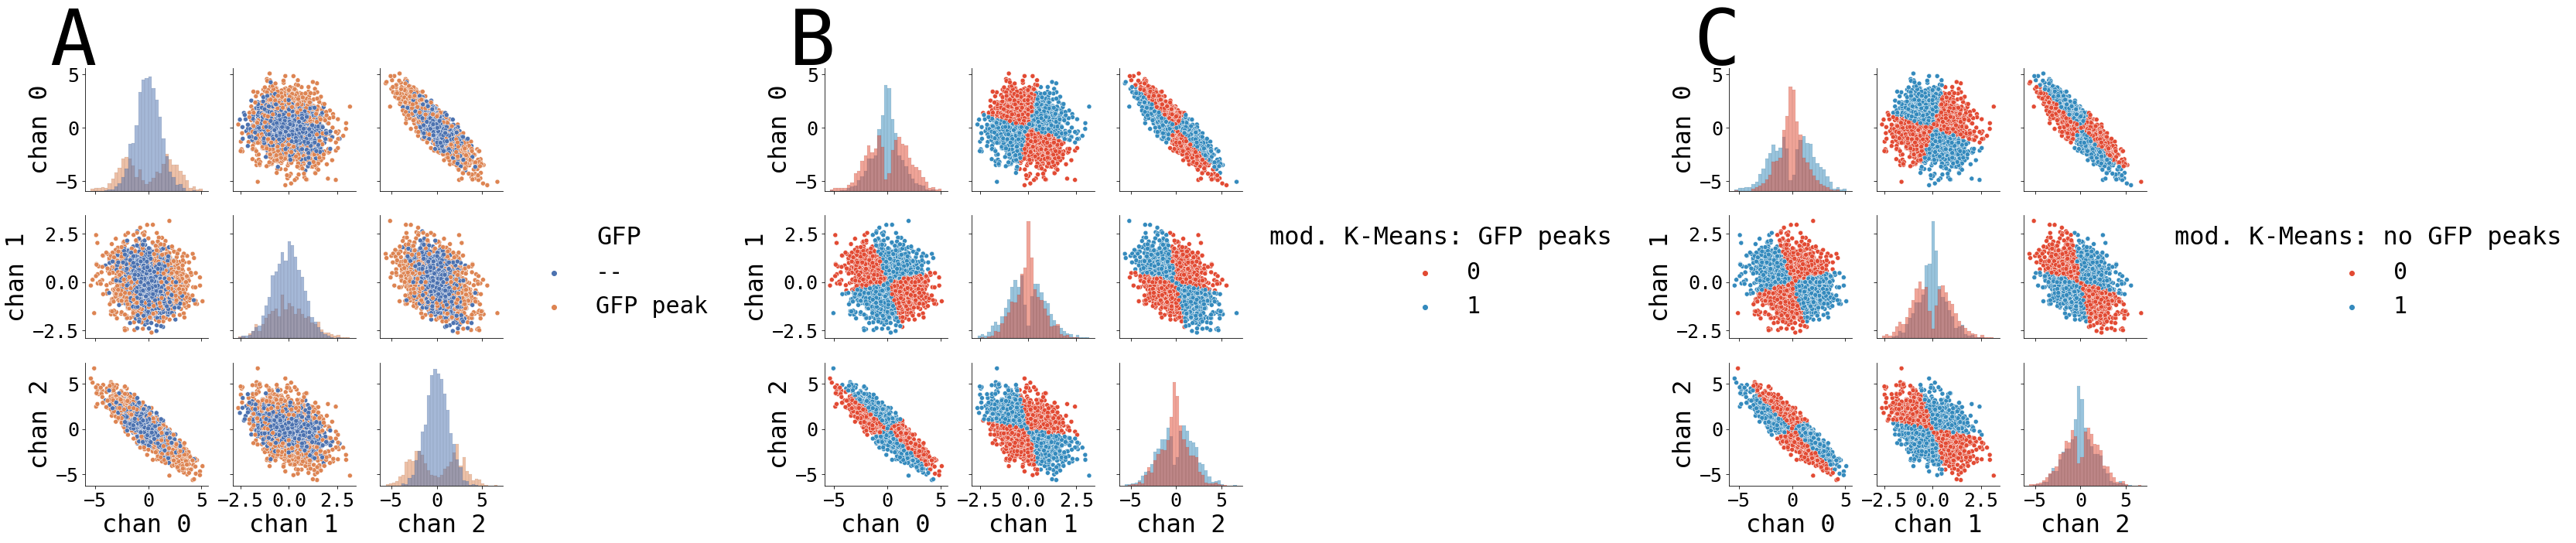

In [11]:
(g0 | g1 | g2).savefig(fname="kmeans_algo.pdf", transparent=True)

In [12]:
recording.run_latent_aahc(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "AAHC", True)

recording.run_latent_aahc(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "AAHC", False)


g = sns.pairplot(data=data, hue="AAHC: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="AAHC: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

display(pg.corr(data["AAHC: GFP peaks"], data["AAHC: no GFP peaks"], method="spearman"))
display(pg.chi2_independence(data, x="AAHC: GFP peaks", y="AAHC: no GFP peaks")[2])

n         r        CI95%  p-val  power
spearman  2500  0.995202  [0.99, 1.0]    0.0    1.0

test    lambda           chi2  dof  pval     cramer  power
0             pearson  1.000000    2472.085559  1.0   0.0   0.994401    1.0
1        cressie-read  0.666667    2609.949990  1.0   0.0   1.021753    1.0
2      log-likelihood  0.000000    3370.244776  1.0   0.0   1.161076    1.0
3       freeman-tukey -0.500000    5160.102777  1.0   0.0   1.436677    1.0
4  mod-log-likelihood -1.000000   11716.474102  1.0   0.0   2.164853    1.0
5              neyman -2.000000  327926.853561  1.0   0.0  11.452980    1.0

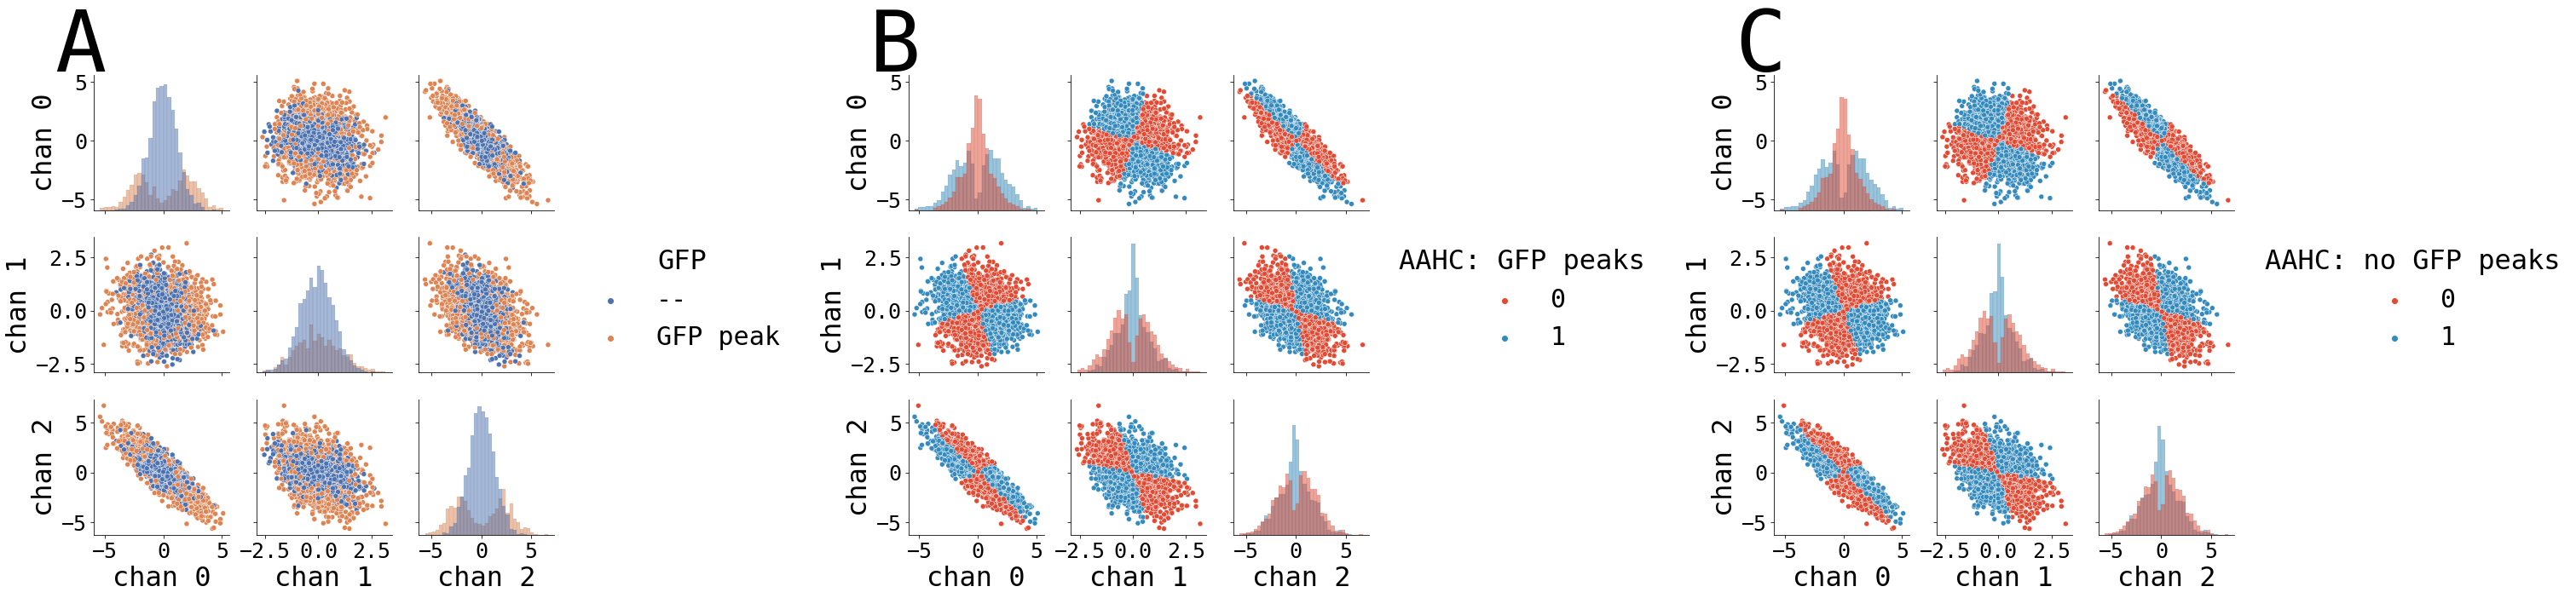

In [13]:
(g0 | g1 | g2).savefig(fname="AAHC_algo.pdf", transparent=True)

In [14]:
recording.run_latent_taahc(N_STATES, use_gfp=True)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "TAAHC", True)

recording.run_latent_taahc(N_STATES, use_gfp=False)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "TAAHC", False)

g = sns.pairplot(data=data, hue="TAAHC: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="TAAHC: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["TAAHC: GFP peaks"], data["TAAHC: no GFP peaks"], method="spearman")
display(corr)
display(pg.chi2_independence(data, x="TAAHC: GFP peaks", y="TAAHC: no GFP peaks")[2])

n         r           CI95%  p-val  power
spearman  2500 -0.992719  [-0.99, -0.99]    0.0    1.0

test    lambda           chi2  dof  pval     cramer  power
0             pearson  1.000000    2459.702147  1.0   0.0   0.991908    1.0
1        cressie-read  0.666667    2585.694792  1.0   0.0   1.016995    1.0
2      log-likelihood  0.000000    3307.367639  1.0   0.0   1.150194    1.0
3       freeman-tukey -0.500000    4991.809965  1.0   0.0   1.413055    1.0
4  mod-log-likelihood -1.000000   10998.809534  1.0   0.0   2.097504    1.0
5              neyman -2.000000  294035.983657  1.0   0.0  10.845017    1.0

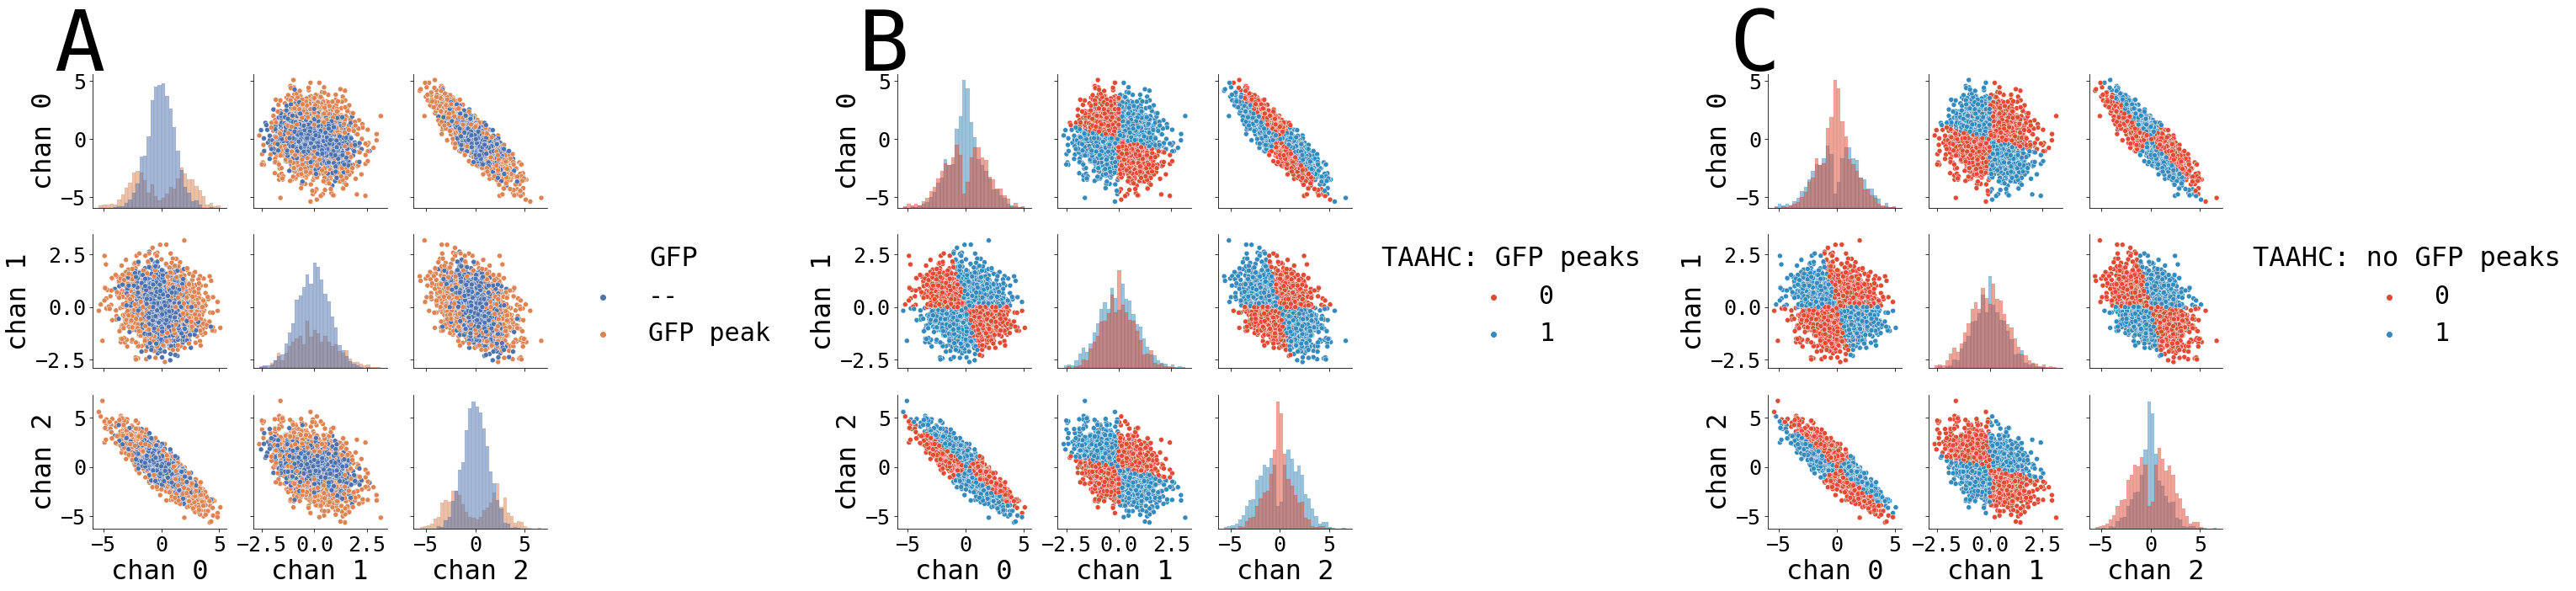

In [15]:
(g0 | g1 | g2).savefig(fname="TAAHC_algo.pdf", transparent=True)

In [16]:
recording.run_latent_hmm(N_STATES, use_gfp=True, envelope=False, pca_preprocess=None)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "HMM", True)

recording.run_latent_hmm(N_STATES, use_gfp=False, envelope=False, pca_preprocess=None)
recording.match_reorder_segmentation(
    reference.values, reference["channels"], return_correlation=False
)
save_suff(recording, "HMM", False)


g = sns.pairplot(data=data, hue="HMM: GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g1 = pw.load_seaborngrid(g)

g = sns.pairplot(data=data, hue="HMM: no GFP peaks", vars=plot_vars, diag_kind="hist")
g.axes[0, 0].text(
    -0.1,
    1.2,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0, 0].transAxes,
    fontsize=100,
)
g2 = pw.load_seaborngrid(g)

corr = pg.corr(data["HMM: GFP peaks"], data["HMM: no GFP peaks"], method="spearman")
display(corr)
display(pg.chi2_independence(data, x="HMM: GFP peaks", y="HMM: no GFP peaks")[2])

n         r          CI95%     p-val    power
spearman  2500 -0.020821  [-0.06, 0.02]  0.298046  0.18033

test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  0.001603  1.0  0.968061  0.000801  0.050184
1        cressie-read  0.666667  0.001603  1.0  0.968066  0.000801  0.050184
2      log-likelihood  0.000000  0.001602  1.0  0.968074  0.000800  0.050184
3       freeman-tukey -0.500000  0.001601  1.0  0.968079  0.000800  0.050183
4  mod-log-likelihood -1.000000  0.001601  1.0  0.968082  0.000800  0.050183
5              neyman -2.000000  0.001601  1.0  0.968087  0.000800  0.050183

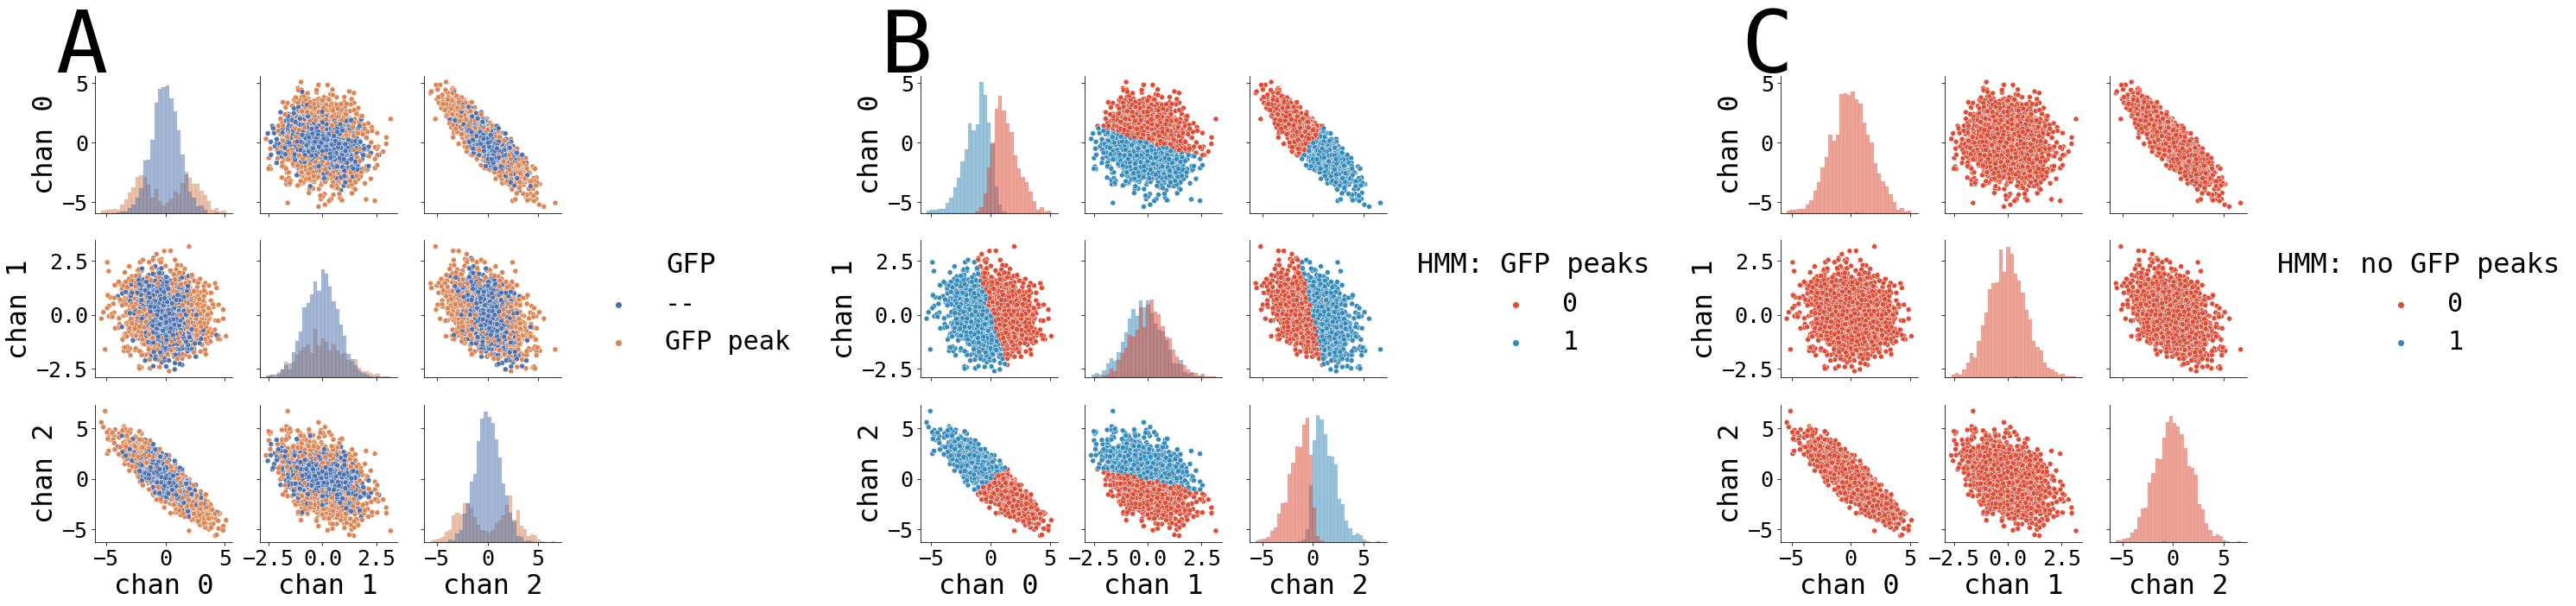

In [17]:
(g0 | g1 | g2).savefig(fname="HMM_algo.pdf", transparent=True)

In [18]:
COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

stats_melt = (
    all_stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm", "latent map", "GFP"],
        value_vars=["coverage", "lifespan", "occurrence"],
    )
)

In [19]:
stats_melt

algorithm latent map           GFP    variable    value
0       AAHC          A     GFP peaks    coverage   0.4880
1       AAHC          B     GFP peaks    coverage   0.5120
2       AAHC          A  no GFP peaks    coverage   0.4864
3       AAHC          B  no GFP peaks    coverage   0.5136
4      TAAHC          A     GFP peaks    coverage   0.4436
..       ...        ...           ...         ...      ...
67       PCA          B  no GFP peaks  occurrence  48.3000
68       ICA          A     GFP peaks  occurrence  60.9000
69       ICA          B     GFP peaks  occurrence  60.9000
70       ICA          A  no GFP peaks  occurrence  60.9000
71       ICA          B  no GFP peaks  occurrence  60.9000

[72 rows x 5 columns]

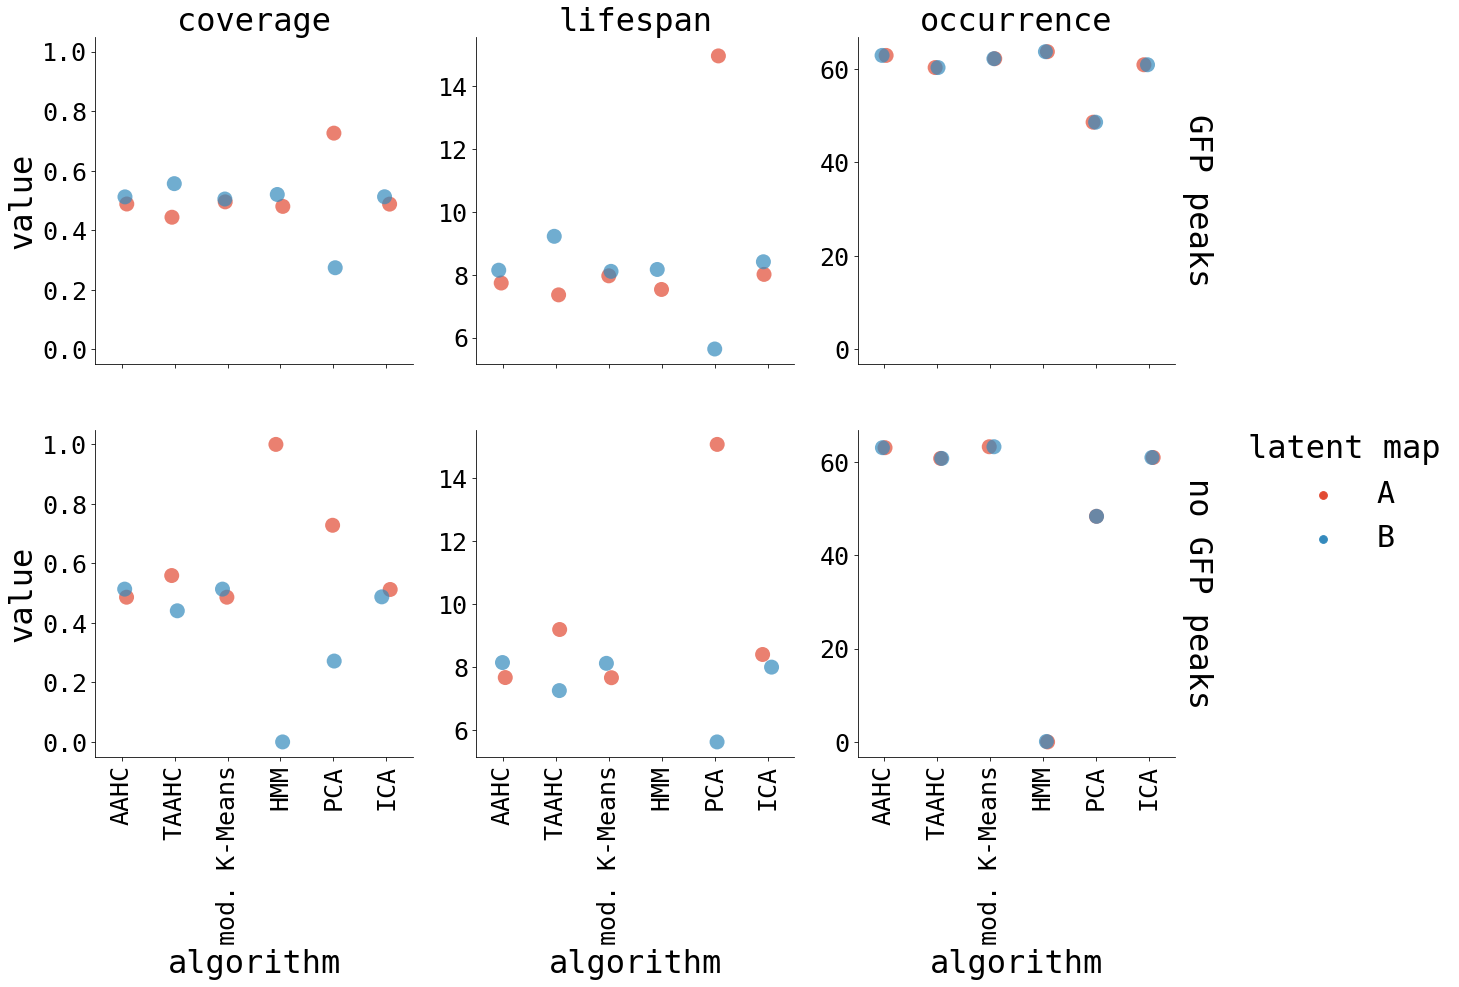

In [20]:
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    s=15,
    alpha=0.7,
    hue="latent map",
    col="variable",
    row="GFP",
    sharex=True,
    sharey="col",
    margin_titles=True,
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

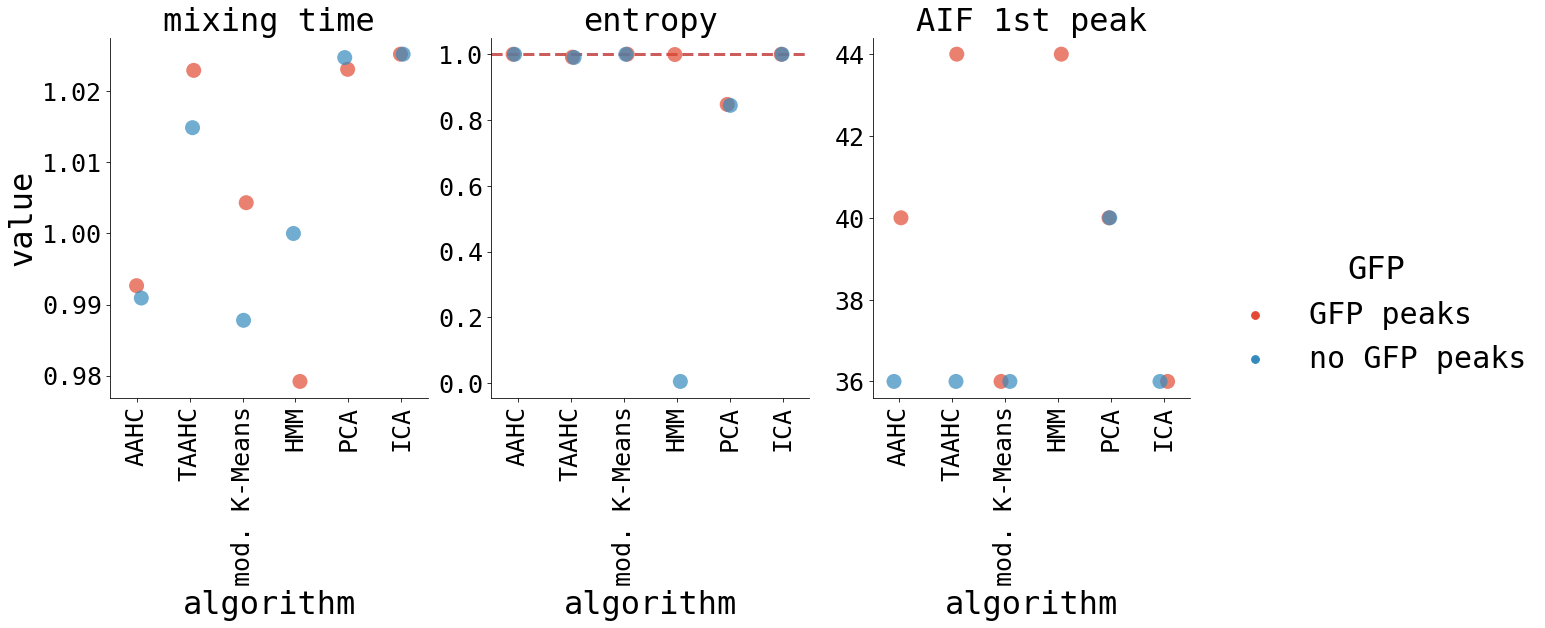

In [21]:
dyn_stats_melt = (
    dyn_stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm", "GFP"],
        value_vars=["mixing time", "entropy", "AIF 1st peak"],
    )
)
g = sns.catplot(
    data=dyn_stats_melt,
    x="algorithm",
    y="value",
    s=15,
    alpha=0.7,
    col="variable",
    hue="GFP",
    sharex=True,
    sharey=False,
    margin_titles=True,
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dyn_stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [22]:
maps = xr.combine_by_coords(maps)
col_ord = sum(
    [[f"{alg}: GFP peaks", f"{alg}: no GFP peaks"] for alg in COLUMNS_ORDER], []
)

In [23]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                for gfp1 in maps["GFP"]:
                    for gfp2 in maps["GFP"]:
                        corrs = (
                            xr.corr(
                                maps.sel(
                                    {"algorithm": alg1, "latent map": map1, "GFP": gfp1}
                                ),
                                maps.sel(
                                    {"algorithm": alg2, "latent map": map2, "GFP": gfp2}
                                ),
                                dim="channels",
                            )
                            .assign_coords(
                                {
                                    "alg1": alg1,
                                    "alg2": alg2,
                                    "map1": map1,
                                    "map2": map2,
                                    "gfp1": gfp1,
                                    "gfp2": gfp2,
                                }
                            )
                            .expand_dims(
                                ["alg1", "alg2", "map1", "map2", "gfp1", "gfp2"]
                            )
                        )
                        all_corrs.append(corrs)
all_corrs = xr.combine_by_coords(all_corrs)

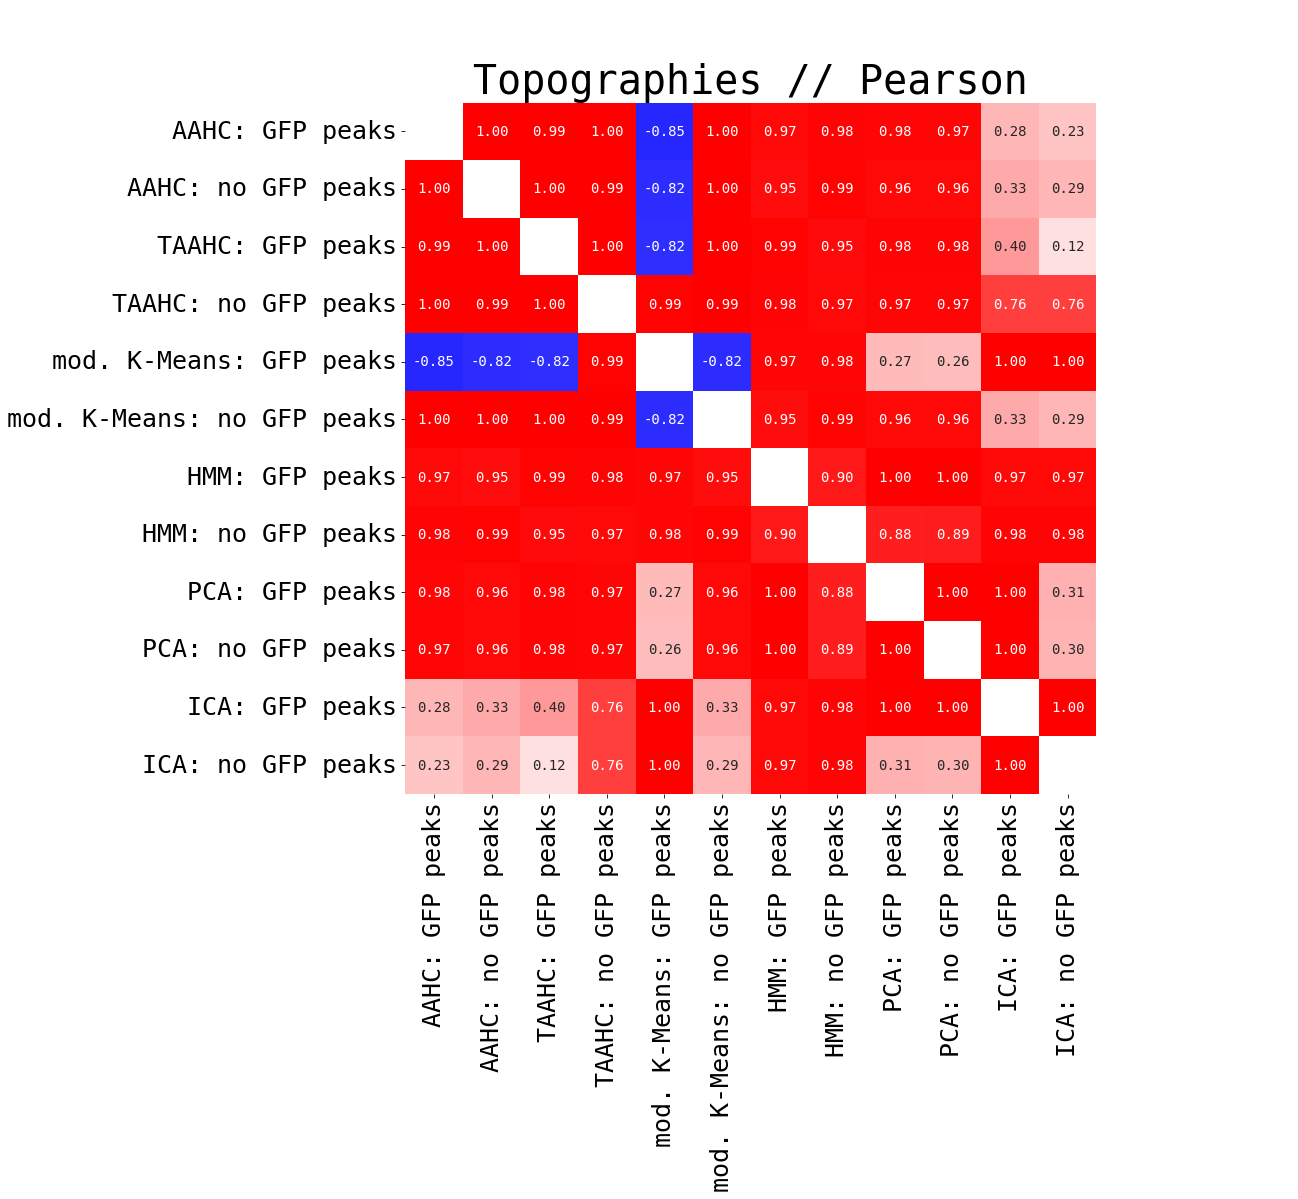

In [24]:
topo_corrs = (
    all_corrs.max(["map1", "map2"])
    .to_series()
    .reset_index()
    .pivot_table(index=["alg1", "gfp1"], columns=["alg2", "gfp2"])
)
topo_corrs.columns = topo_corrs.columns.droplevel(0)
topo_corrs.columns = [": ".join(col).strip() for col in topo_corrs.columns.values]
topo_corrs.index = [": ".join(idx).strip() for idx in topo_corrs.index.values]
topo_corrs = topo_corrs.loc[col_ord, col_ord]
np.fill_diagonal(topo_corrs.values, np.nan)

g6 = pw.Brick("ax", figsize=(12, 12))
sns.heatmap(
    topo_corrs,
    square=True,
    vmax=1.0,
    vmin=-1,
    cmap="bwr",
    annot=topo_corrs,
    fmt=".2f",
    annot_kws={"fontsize": 14},
    ax=g6,
)
g6.set_title("Topographies // Pearson")
g6.savefig(quick=True)

In [25]:
corr_data = data[data.columns[4:]].loc[:, col_ord]

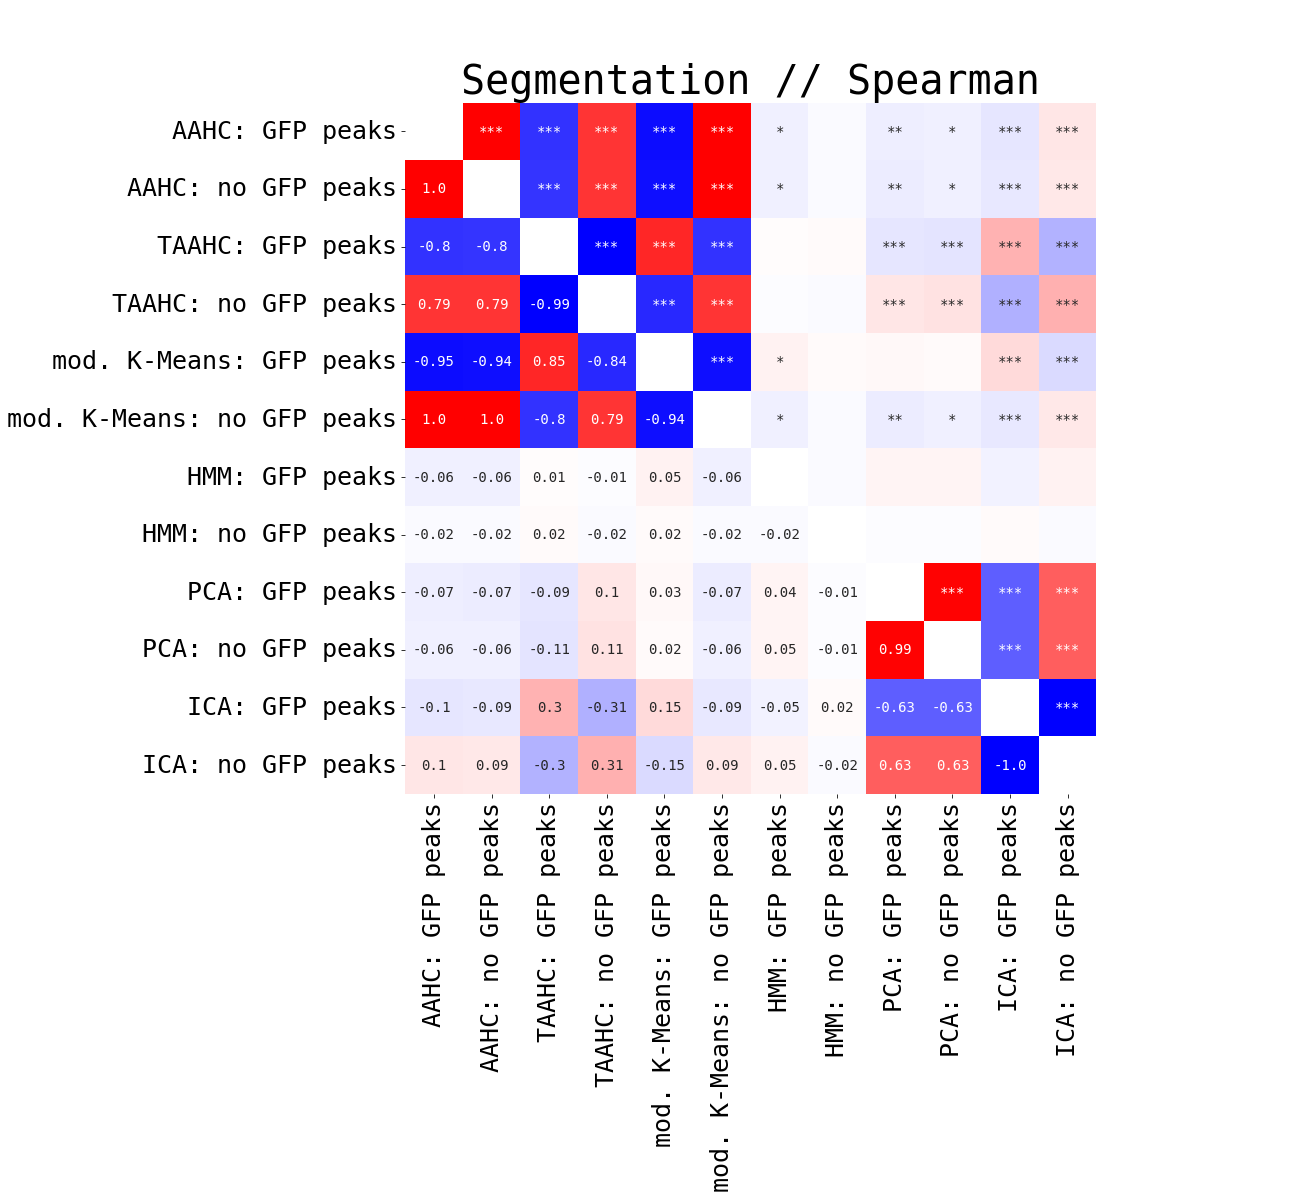

In [26]:
rcorrs = corr_data.corr("spearman")
np.fill_diagonal(rcorrs.values, np.nan)
g7 = pw.Brick("ax2", figsize=(12, 12))
sns.heatmap(
    rcorrs,
    square=True,
    vmax=1.0,
    vmin=-1,
    cmap="bwr",
    annot=corr_data.rcorr("spearman", padjust="fdr_by", decimals=2),
    fmt="",
    annot_kws={"fontsize": 14},
    ax=g7,
)
g7.set_title("Segmentation // Spearman")
g7.savefig(quick=True)

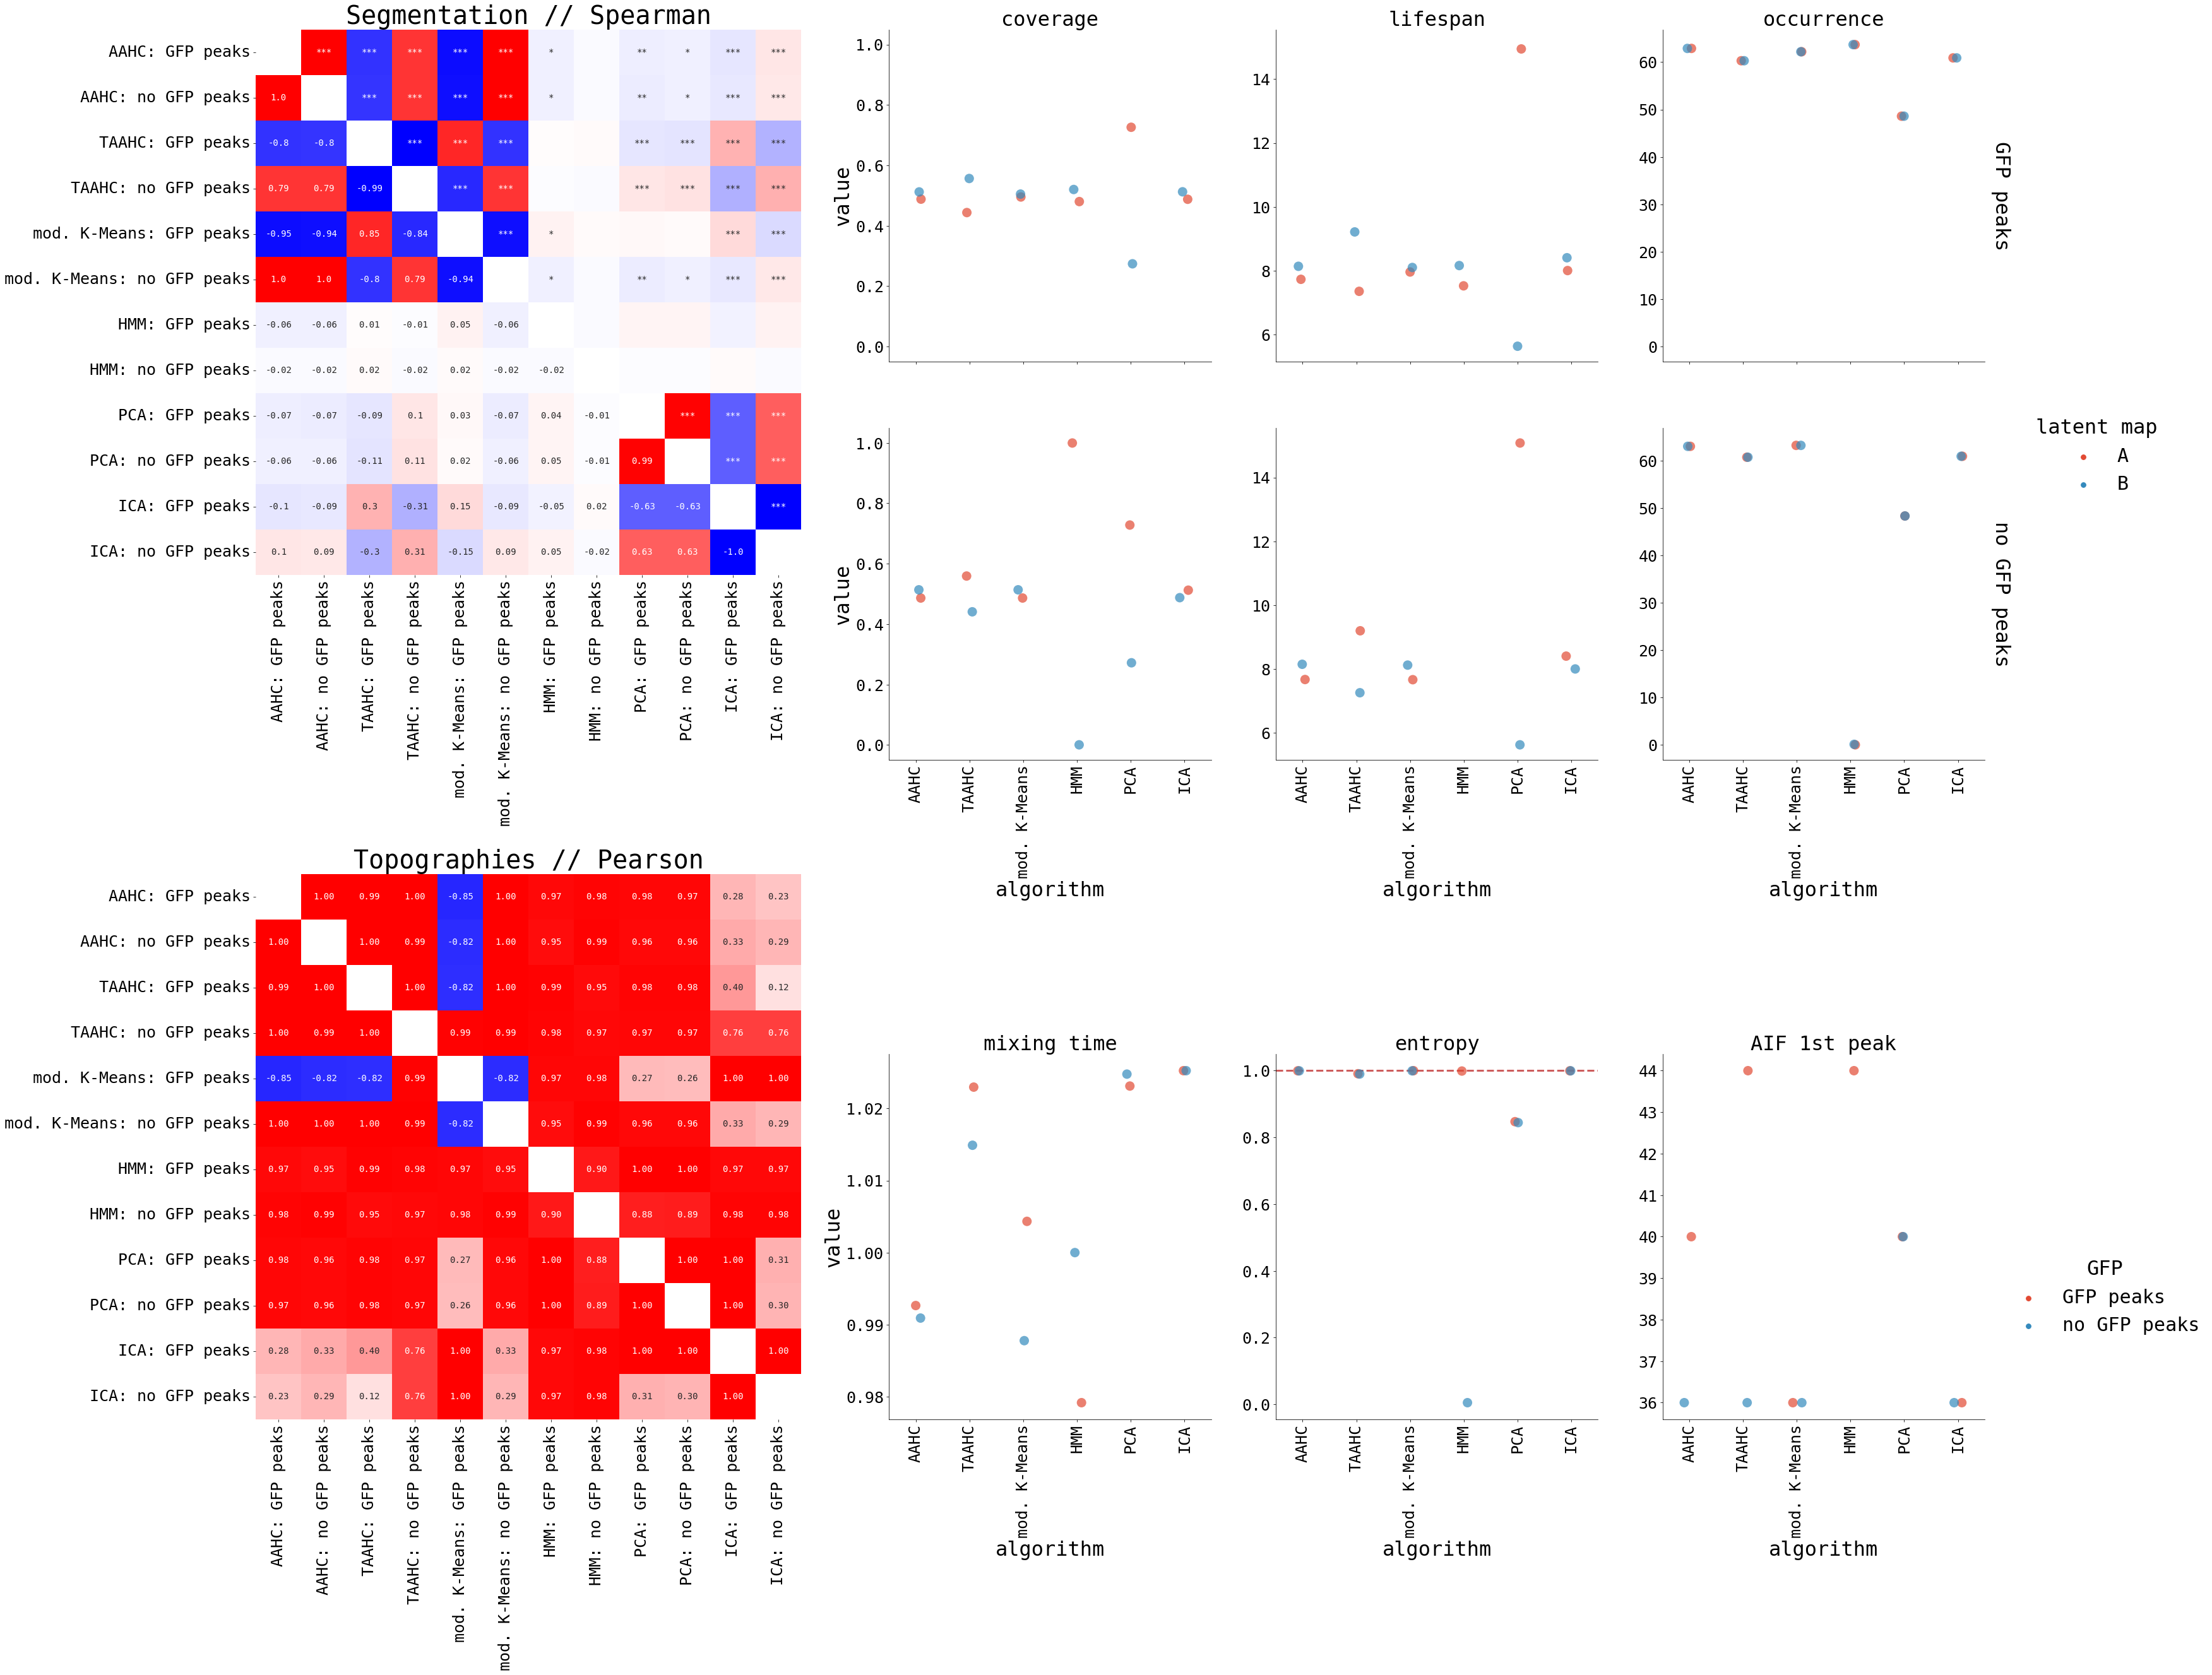

In [27]:
((g7 / g6) | (g4 / g5)).savefig(fname="synthetic_single_stats.pdf", transparent=True)